# Modelling Revenue Tiers

Thus far in this project I've been able to instantiate and train machine learning models on a data set that reflects the traits of two thousand films, and predict those films revenue accurately. 

The final step in this project is to examine the film data and ascertain if there are any 'tiers' that can be used to group films together and more accurately model revenue on subsets of the data.  

I'll first conduct some preliminary exploration of the data looking for likely ways to group films according to my intuition, then use a clustering model to generate additional insights onto how these films should be grouped. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [15]:
box = pd.read_csv('../Data/Reduced_dimensions.csv', index_col=0, header = [0,1])
box.head(3)

Genre                                                                    \
  Action Adventure Animation Comedy Crime Documentary Drama Family Fantasy   
0      0         0         0      1     0           0     1      1       0   
1      0         0         0      0     0           0     1      0       0   
2      0         1         1      0     0           0     0      1       0   

           ... Release_year                    Numerical Country               \
  Foreign  ...          00s 10s Num_production_countries  Europe Oceania Asia   
0       0  ...            1   0                        1       0       0    0   
1       0  ...            0   1                        1       0       0    0   
2       0  ...            0   0                        1       0       0    0   

                                                  
  Middle_East Latin_America North_America Africa  
0           0             0             0      0  
1           0             0             0      0  
2           0             0             0      0  

[3 rows x 88 columns]

### Initial examination

Based on prior work in a dedicated EDA notebook I believer that I have several 'likely' places that will be relatively easy to divide films on in order to model revenue.  These will have the added benefit of being interpretable as well.  

Genre is an intuitive place to divide films for modelling by revenue, but does present some challenges. First, each film may belong to multiple generes, which means it will be difficult to subdivide these films into clean categories in order to accurately model revenue. 

Much easier will be to model revenue based on release year and month.  I'll be taking the opportunity to model this based on decade as well as 'season' based on the release month.  

### Modelling by genre

Here I need to evaluate how the genre category can be used to segment films into revenue tiers that can be individually modeled in order to provide more accuracy with the models themselves. 

In [26]:
# Creating new df of only genre and revenue information
Genres = box['Genre']
Genres['Num_genres'] = box['Genre'].sum(axis=1)
rev = pd.DataFrame(box['Numerical', 'revenue'])
rev.columns = rev.columns.droplevel()
Genres = Genres.join(rev)
Genres

<ipython-input-26-4cf78b35a631>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Genres['Num_genres'] = box['Genre'].sum(axis=1)


,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,...,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,Num_genres,revenue
0,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,4,134734481.00000
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,48982041.00000
2,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3,3418605.00000
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,2,85446075.00000
4,1,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,5,4259710.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,2,95437994.00000
2329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,71171825.00000
2330,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,3,3190832.00000
2331,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,4,440603537.00000


In [20]:
Genres.Num_genres.value_counts()

3    748
2    620
4    367
1    353
5    107
6     18
7      2
0      1
Name: Num_genres, dtype: int64

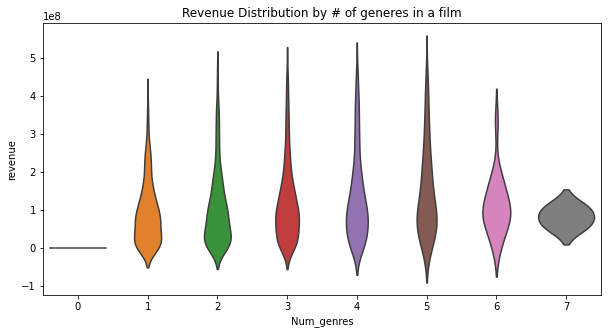

In [25]:
# It seems that the number of genres in a film could be a good way to divide up the films for modeling
plt.figure(figsize=(10,5))
sns.violinplot(x='Num_genres', y='revenue', data=Genres, inner=None)
plt.title('Revenue Distribution by # of generes in a film');

It doesn't appear that the number of genres presents a good opportunity to model revenue based off of revenue performance.  I'm going to take a look at the distribution of revenue among different genres.  In order to do so I need to engineer a new data frame from the 'Genres' one that is compatible with seaborn violin plots.  The idea to set revenue as the data frame index, then reset the index in order to accomplishe this came from this [stack overflow](https://stackoverflow.com/questions/50607740/reverse-a-get-dummies-encoding-in-pandas) questions.  

I've plotted the results in a violin plot below. 

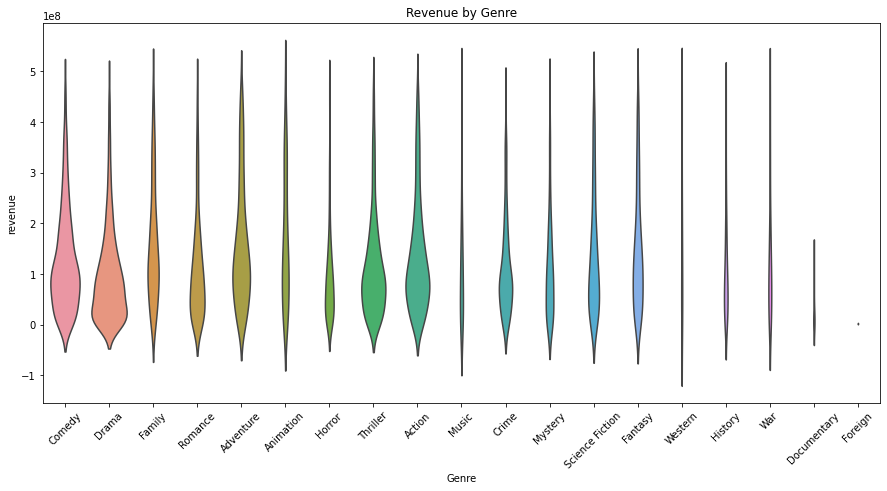

In [52]:
g = Genres.drop('Num_genres', axis=1)
g.set_index('revenue', inplace=True)
g = g[g==1].stack().reset_index().drop(0, axis=1)
plt.figure(figsize=(15,7))
sns.violinplot(x='level_1', y='revenue', data=g, scale='count', inner=None)
plt.title('Revenue by Genre')
plt.xticks(rotation=45)
plt.xlabel('Genre');

There are some interesting things that go on with the revenue distribution for Drama and Comedy, however based on this plot it doesn't seem that genres will be a good way to 'tier' films for different models.

### Modeling revenue by year

It was fairly clear in the initial exploratory analysis that there was an overall rise in film revenue as time has progressed. I want to take a look at what the revenue distributions look like as a result of that. 

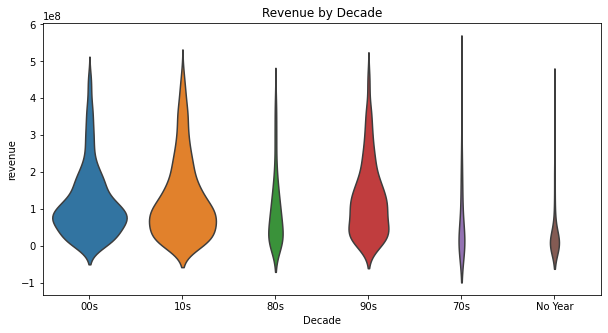

In [61]:
year = box.Release_year
rev = pd.DataFrame(box['Numerical', 'revenue'])
rev.columns = rev.columns.droplevel()
year = year.join(rev)
year.set_index('revenue', inplace=True)
year = year[year == 1].stack().reset_index().drop(0, axis=1)
plt.figure(figsize=(10,5))
sns.violinplot(x='level_1', y='revenue', data=year, scale='count', inner=None)
plt.xlabel('Decade')
plt.title('Revenue by Decade');

In [65]:
box.Release_year.value_counts()

No Year  70s  80s  90s  00s  10s
0        0    0    0    1    0      784
                        0    1      705
                   1    0    0      420
              1    0    0    0      151
1        0    0    0    0    0       95
0        1    0    0    0    0       61
dtype: int64

It does seem that using decades to divide this dataset in order to more accurately model revenue would produce different results, since the distribution of film revenue has clear differences from decade to decade.  If successful this could prove valuable since modeling future performance would be based on the most recent decade

### Modelling revenue by seasonality

Another option for modelling revenue is to do so by month or seasonality.  I'll need to group this data into seasons in order to see if either present stronger options than just by decade. 

In [67]:
month = box.Release_month

,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2328,0,0,0,0,1,0,0,0,0,0,0,0
2329,0,0,0,0,0,0,0,0,1,0,0,0
2330,0,0,0,0,0,1,0,0,0,0,0,0
2331,0,0,0,0,0,1,0,0,0,0,0,0
